# Lab 4

### Import

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

### TensorFlow Datasets

安裝：

```
pip install tensorflow-datasets
```
or 

```
pip install git+https://github.com/tensorflow/datasets.git
```



顯示TensorFlow Datasets目前提供的數據集

In [9]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'criteo',
 'cs_restaurants',
 'cura

### 讀取數據並分析
載入Cifar10數據集

In [2]:
# 將train Data重新分成1:9等分，分別分給valid data, train data
train_split, valid_split = ['train[:90%]', 'train[90%:]']
# 取得訓練數據，並順便讀取data的資訊
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)
# 取得測試數據
test_data = tfds.load("cifar10", split='test')

顯示Cifar10數據集資訊

In [5]:
print(info)

NameError: name 'info' is not defined

Cifar10的十個標籤

In [3]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

查看訓練資料，並計算每個類別的數量：

In [4]:
# 建立一個dict用來計數每個類別標籤數量
train_dict = {}
# 讀取整個訓練資料集
for data in train_data:
    # 將讀取到的label轉乘numpy格式
    label = data['label'].numpy()
    # 以label沒dict的key，取出dict中的值+1，如果key在dict中沒有值預設為0
    train_dict[label] = train_dict.setdefault(label, 0) + 1
    # train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


顯示數據集部分影像資料：

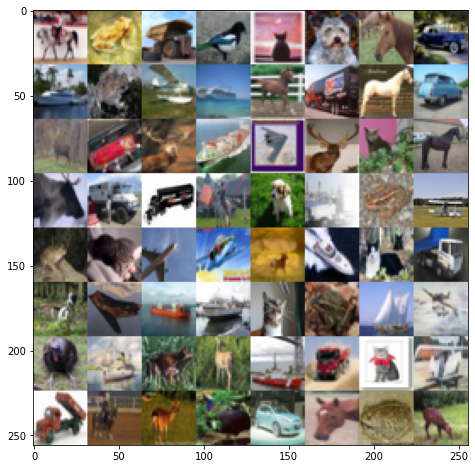

In [5]:
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
# 每一次取8比資料，共取8次，所以總共取得64比資料
for data in train_data.batch(8).take(8):
    # 將取得的8比堆疊起來，放入顯示影像陣列第N列中
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
# 設定顯示視窗大小
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

### Dataset 設定

資料愈處理(Data Prepossessing ):
- 影像資料：將輸入資料做標準化，全部除以255，將像素值縮放到0~1之間。
- 標籤資料：做One-hot Encoding，例如類別2為[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]。

In [6]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

Dataset設定：

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入前面的資料愈處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1（全連接神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄30%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [8]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x) 
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0   

創建紀錄檔目錄

In [9]:
model_dir = 'lab4-logs/models'  # 設定儲存權重目錄
try:
    os.makedirs(model_dir)  # 創建儲存權重目錄
except:
    pass

建立Callback function：

In [10]:
# 將訓練記錄，存成TensorBoard的紀錄檔
log_dir = os.path.join('lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-1')
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

設定訓練使用的優化器、損失函數和指標函數

In [11]:
model_1.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100


W0613 17:06:17.499904 139682198697792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


704/704 [==============================] - 17s 25ms/step - loss: 1.9916 - categorical_accuracy: 0.2615 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 14s 20ms/step - loss: 1.8335 - categorical_accuracy: 0.3410 - val_loss: 1.7940 - val_categorical_accuracy: 0.3548
Epoch 3/100
704/704 [==============================] - 13s 19ms/step - loss: 1.7764 - categorical_accuracy: 0.3616 - val_loss: 1.7707 - val_categorical_accuracy: 0.3690
Epoch 4/100
704/704 [==============================] - 13s 19ms/step - loss: 1.7231 - categorical_accuracy: 0.3825 - val_loss: 1.6771 - val_categorical_accuracy: 0.4002
Epoch 5/100
704/704 [==============================] - 13s 18ms/step - loss: 1.6904 - categorical_accuracy: 0.3979 - val_loss: 1.6925 - val_categorical_accuracy: 0.3988
Epoch 6/100
704/704 [==============================] - 13s 18ms/step - loss: 1.6616 - categorical_accuracy: 0.4080 - val_loss: 1.6750 - val_categorical_accurac

704/704 [==============================] - 12s 18ms/step - loss: 1.1100 - categorical_accuracy: 0.5929 - val_loss: 2.1994 - val_categorical_accuracy: 0.3888
Epoch 98/100
704/704 [==============================] - 13s 18ms/step - loss: 1.0720 - categorical_accuracy: 0.6076 - val_loss: 2.2483 - val_categorical_accuracy: 0.3842
Epoch 99/100
704/704 [==============================] - 13s 18ms/step - loss: 1.0879 - categorical_accuracy: 0.6053 - val_loss: 2.3221 - val_categorical_accuracy: 0.3768
Epoch 100/100
704/704 [==============================] - 12s 17ms/step - loss: 1.0875 - categorical_accuracy: 0.6019 - val_loss: 2.2232 - val_categorical_accuracy: 0.3914


驗證在測試集上：

In [14]:
model_1 = keras.models.load_model('lab4-logs\models\Best-model-1.hdf5')

loss, acc = model_1.evaluate(test_data)
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 3ms/step - loss: 1.8056 - categorical_accuracy: 0.3727

Model-1 Accuracy: 0.3727000057697296%


### 訓練Model-2（卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [15]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         295040    
                                                           

建立Callback function：

In [16]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

設定訓練使用的優化器、損失函數和指標函數

In [17]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型

In [ ]:
history_2 = model_2.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 21s 29ms/step - loss: 1.8988 - categorical_accuracy: 0.2836 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 17s 24ms/step - loss: 1.5298 - categorical_accuracy: 0.4449 - val_loss: 1.2727 - val_categorical_accuracy: 0.5304
Epoch 3/100
704/704 [==============================] - 18s 25ms/step - loss: 1.3552 - categorical_accuracy: 0.5170 - val_loss: 1.2537 - val_categorical_accuracy: 0.5502
Epoch 4/100
704/704 [==============================] - 17s 25ms/step - loss: 1.2461 - categorical_accuracy: 0.5554 - val_loss: 1.1136 - val_categorical_accuracy: 0.5996
Epoch 5/100
704/704 [==============================] - 17s 24ms/step - loss: 1.1478 - categorical_accuracy: 0.5939 - val_loss: 1.0418 - val_categorical_accuracy: 0.6220
Epoch 6/100
704/704 [==============================] - 17s 24ms/step - loss: 1.0598 - categorical_accuracy: 0.6272 - val_loss: 0.9812 - val_categor

704/704 [==============================] - 17s 24ms/step - loss: 0.0966 - categorical_accuracy: 0.9723 - val_loss: 2.2025 - val_categorical_accuracy: 0.7182
Epoch 98/100
704/704 [==============================] - 17s 24ms/step - loss: 0.1025 - categorical_accuracy: 0.9703 - val_loss: 2.2492 - val_categorical_accuracy: 0.7088
Epoch 99/100
704/704 [==============================] - 17s 24ms/step - loss: 0.0996 - categorical_accuracy: 0.9717 - val_loss: 2.2774 - val_categorical_accuracy: 0.7240
Epoch 100/100
704/704 [==============================] - 17s 24ms/step - loss: 0.0972 - categorical_accuracy: 0.9719 - val_loss: 2.2583 - val_categorical_accuracy: 0.7116


驗證在測試集上：

In [18]:

model_2 = keras.models.load_model('lab4-logs\models\Best-model-2.hdf5')

loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

157/157 [==============================] - 6s 40ms/step - loss: 4.1606 - categorical_accuracy: 0.5353

Model-2 Accuracy: 0.5353000164031982%


### 影像增強(Image Augmentation)

取一張影像作為測試使用

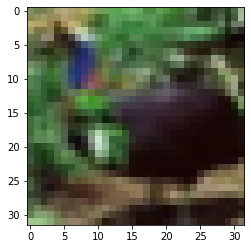

In [19]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

水平翻轉：

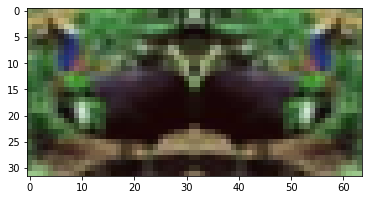

In [20]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

顏色轉換：

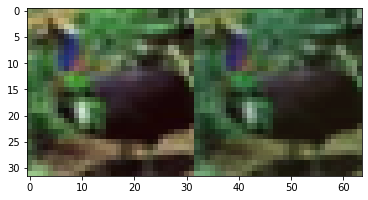

In [21]:
def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

影像旋轉：

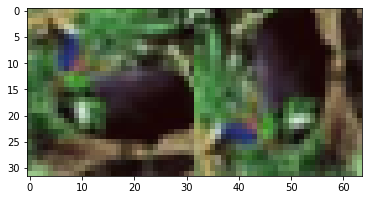

In [22]:
def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

影像縮放：

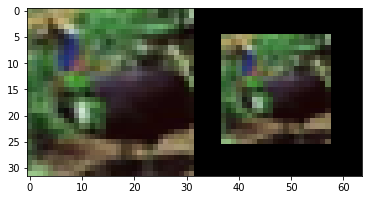

In [23]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

image_2 = zoom(image_test)
# 因為處理後影像會變成float型態，所以需轉換回來不然顯示時會出現問題
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))  # 將原始圖和處理後水平合併
plt.imshow(image)


### Dataset 設定 (Augmentation)

重新載入一次Dataset(因為前面已經對Dataset設定過了)

In [24]:
train_data = tfds.load("cifar10", split=train_split)

資料愈處理(Data Prepossessing ):
-	標準化：將影像全部除以255，將像素值縮放到0~1之間。
-	影像增強：將影像水平翻轉、影像旋轉、顏色轉換和影像縮放。
-	標籤資料：做One-hot Encoding，例如類別2為[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]。


In [25]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['label'], 10)
    return x, y

Dataset設定：

In [26]:
# 打散資料集
train_data = train_data.shuffle(train_num)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

測試Dataset經過Augmentation後的結果

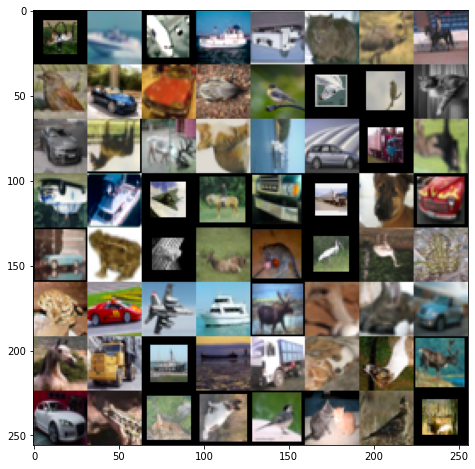

In [27]:
# 由於前面已經將train_data batch size設定為64，所以取一次資料就有64筆
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

### 訓練Model-3（使用影增強方法訓練卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [28]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # 顯示網路架構

Model: "model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 128)         295040    
                                                           

建立Callback function：

In [29]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

設定訓練使用的優化器、損失函數和指標函數

In [30]:
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

訓練網路模型

In [ ]:
history_3 = model_3.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 14s 21ms/step - loss: 2.0500 - categorical_accuracy: 0.2298 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 12s 17ms/step - loss: 1.8638 - categorical_accuracy: 0.3104 - val_loss: 1.5882 - val_categorical_accuracy: 0.4082
Epoch 3/100
704/704 [==============================] - 12s 17ms/step - loss: 1.7224 - categorical_accuracy: 0.3686 - val_loss: 1.4165 - val_categorical_accuracy: 0.4902
Epoch 4/100
704/704 [==============================] - 12s 17ms/step - loss: 1.6336 - categorical_accuracy: 0.4096 - val_loss: 1.3202 - val_categorical_accuracy: 0.5244
Epoch 5/100
704/704 [==============================] - 12s 17ms/step - loss: 1.5621 - categorical_accuracy: 0.4393 - val_loss: 1.2695 - val_categorical_accuracy: 0.5480
Epoch 6/100
704/704 [==============================] - 12s 17ms/step - loss: 1.4950 - categorical_accuracy: 0.4674 - val_loss: 1.1529 - val_categor

704/704 [==============================] - 19s 27ms/step - loss: 0.7597 - categorical_accuracy: 0.7480 - val_loss: 0.6400 - val_categorical_accuracy: 0.7992
Epoch 98/100
704/704 [==============================] - 19s 27ms/step - loss: 0.7577 - categorical_accuracy: 0.7466 - val_loss: 0.6118 - val_categorical_accuracy: 0.8020
Epoch 99/100
704/704 [==============================] - 19s 27ms/step - loss: 0.7619 - categorical_accuracy: 0.7490 - val_loss: 0.6347 - val_categorical_accuracy: 0.8022
Epoch 100/100
704/704 [==============================] - 19s 27ms/step - loss: 0.7608 - categorical_accuracy: 0.7474 - val_loss: 0.6132 - val_categorical_accuracy: 0.8034


驗證在測試集上：

In [31]:
model_3 = keras.models.load_model('lab4-logs\models\Best-model-3.hdf5')

loss, acc = model_3.evaluate(test_data)
print('\nModel-3 Accuracy: {}%'.format(acc))

157/157 [==============================] - 6s 40ms/step - loss: 1.1174 - categorical_accuracy: 0.6200

Model-3 Accuracy: 0.6200000047683716%


### 比較三種網路的訓練結果

讀取各自最佳的網路權重：

In [32]:
model_1.load_weights('lab4-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab4-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab4-logs/models/Best-model-3.hdf5')
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 7s 45ms/step - loss: 1.1174 - categorical_accuracy: 0.6200


驗證在測試集數據上：

In [33]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 7s 46ms/step - loss: 1.1174 - categorical_accuracy: 0.6200


顯示預測的損失值與準確度結果：

In [34]:
loss = [loss_1, loss_2, loss_3]  
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,  
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,1.805564,0.3727
1,4.160637,0.5353
2,1.117446,0.6200
